In [1]:
%pip install scipy
import numpy as np 
import matplotlib.pyplot as plt
import skimage
import cv2
from functions import *
from scipy.ndimage import affine_transform
from function_week_3 import*

Note: you may need to restart the kernel to use updated packages.


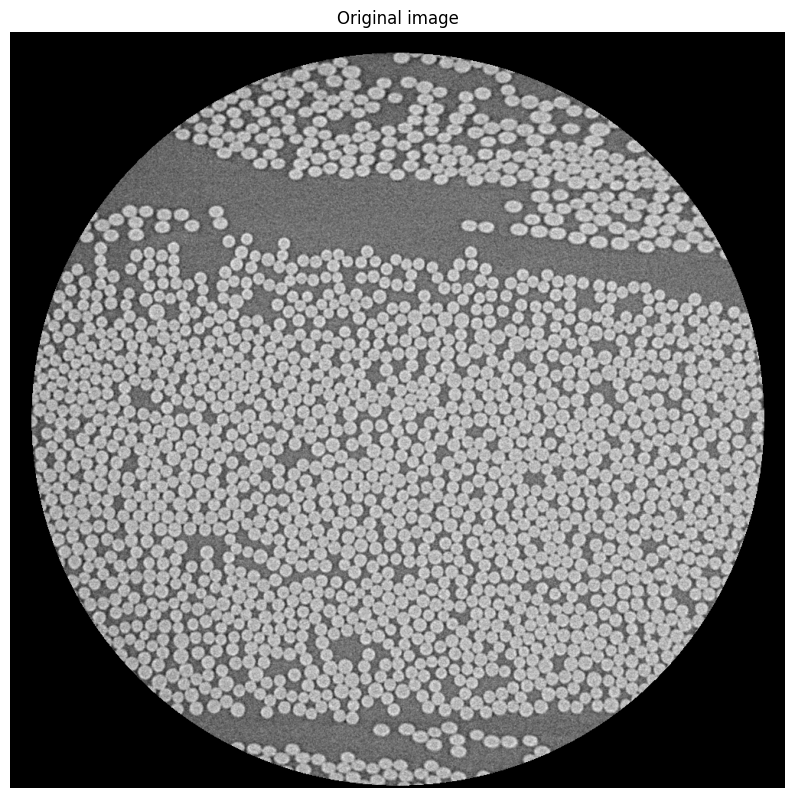

In [2]:
# load the iamge 

image_1 = get_gray_image('data/CT_lab_high_res.png')
image_2 = get_gray_image('data/CT_lab_high_res.png')


visualize_the_image(image=image_1)

In [3]:
def transform_image(t, s, theta, image, indexes): 
    # rotation matrix
    R = np.array([[np.cos(theta), -np.sin(theta)], 
                [np.sin(theta),  np.cos(theta)]])
    # rotate and transform

    t = t.reshape(-1,1)
    image_ = affine_transform(image, np.hstack([R,t]))
    image_2 = s * image_
    # crop the image 
    image_3 = image_2[indexes[0]:indexes[1], indexes[0]:indexes[1]]

    return image_3

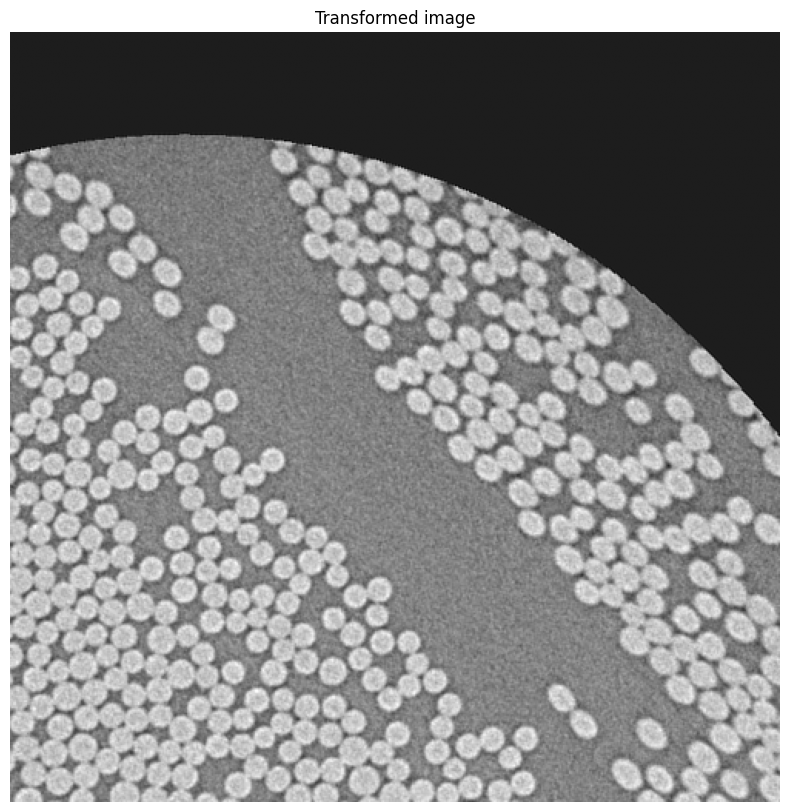

In [4]:
t = np.array([200, -100])
theta = np.pi / 4
s = 1
indexes = (100, 600)

image_2 = transform_image(t, s,theta, image_2, indexes )



visualize_the_image(image_2, 'Transformed image')



image_1 = cv2.cvtColor((image_1 * 255).astype(np.uint8), cv2.IMREAD_GRAYSCALE)
image_2 = cv2.cvtColor((image_2 * 255).astype(np.uint8), cv2.IMREAD_GRAYSCALE)
# convert image to greyscale 

In [5]:
# Initialize the sift detectoor
sift = cv2.SIFT_create()

In [6]:
# detect keypoints and descripors with the sift detector
keypoints1, descriptiors1 = sift.detectAndCompute(image_1, None)
keypoints2, descriptiors2 = sift.detectAndCompute(image_2, None)


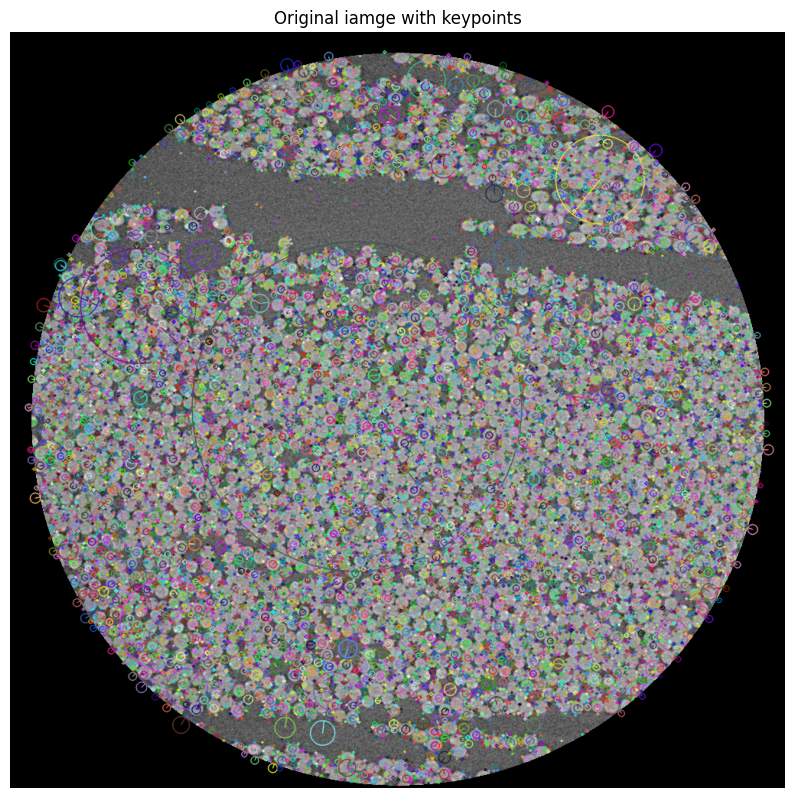

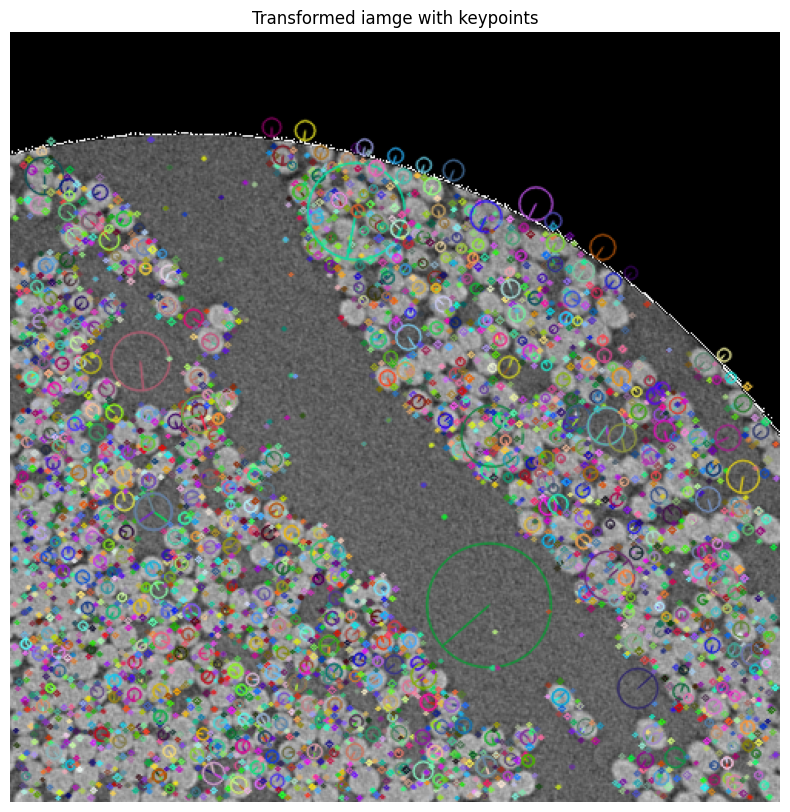

In [7]:
# Draw the keypoints on the images with rich keypoints (which is keypoints with size and orientation)
image1_with_kp = cv2.drawKeypoints(image_1, keypoints1, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS) # DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS: For each keypoint, the circle around keypoint with keypoint size and orientation will be drawn.
image2_with_kp = cv2.drawKeypoints(image_2, keypoints2, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS) # DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS: For each keypoint, the circle around keypoint with keypoint size and orientation will be drawn.


visualize_the_image(image1_with_kp, 'Original iamge with keypoints')
visualize_the_image(image2_with_kp, 'Transformed iamge with keypoints')

# Info about CrossCheck True and False 
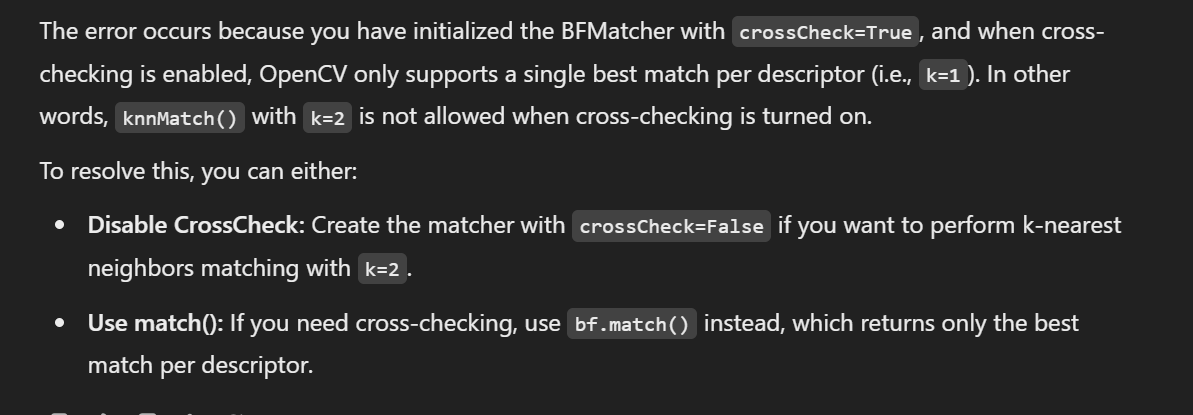

In [8]:
# Initialize the Open CV matcher - I use the Brute-Force matcher with L2 Norm 
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)

In [9]:
# find k-Nearest Neighbours 
# for each descriptor in the original image, find the two nearest descriptors in the transformed image 

matches = bf.knnMatch(descriptiors1, descriptiors2, k=2)


Number of good matches found 2768


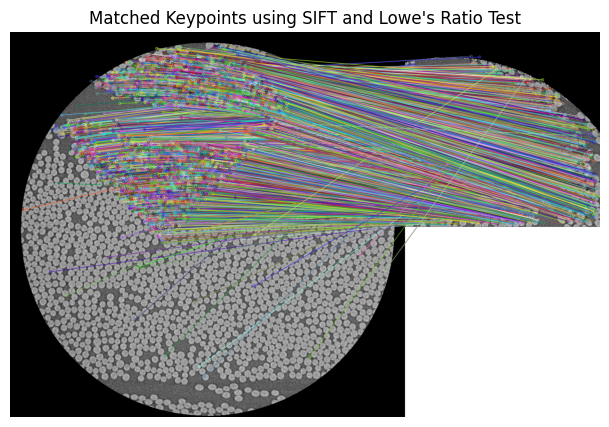

In [10]:
good_match = []


# loop through the coordinates of a original (m) and transformed (n)
# to access the distance use .distance 

for m, n in matches: 
    #print(m.distance)
    #print(n.distance)
    #print(f"Original image distance {m.distance}")
    #print(f"Transformed distance {n.distance}")
    #print(f"The 0.6 Lowe criterion of the transformed image {0.6 * n.distance}")
    #print(f"Determine if good match or not {m.distance < 0.6 * n.distance}")
    if m.distance < 0.6 * n.distance:
        good_match.append(m)


print(f"Number of good matches found {len(good_match)}")



matched_img = cv2.drawMatches(image_1, keypoints1, image_2, keypoints2, good_match, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize=(10, 5))
plt.title("Matched Keypoints using SIFT and Lowe's Ratio Test")
plt.imshow(matched_img)
plt.axis('off')
plt.show()

In [18]:
#From yjr list of good matches (obtained using Lowe’s ratio test), each match object contains two indices:
#queryIdx: Index of the keypoint in image1.
#trainIdx: Index of the keypoint in image2.
#Use these indices to extract the (x, y) coordinates from the keypoints of both images.
#This gives you two corresponding sets of points: one from image1 (p_set) and one from image2 (q_set).




p_set = np.array([keypoints1[m.queryIdx].pt for m in good_match])
q_set = np.array([keypoints2[m.trainIdx].pt for m in good_match])

# Optional: print the number of matching points
print("Number of matching points:", len(p_set))

Number of matching points: 2768


In [19]:
# compute the uniform scale factor 

s_prime = compute_scale(p_set, q_set)

print(rf"The value of s' = {s_prime} the original value of s = {s}")

The value of s' = 0.9873963880860078 the original value of s = 0.9716513513199344


In [20]:
R_hat = covariance_matrix(p_set, q_set)

print(f"The value of R_hat is {R_hat} the original value of theta = {theta}")

The mean of p is  (2,)
The shape of U is  (2, 2)
The shape of sigma is  (2,)
The shape of Vt is  (2, 2)
Sign of det is  0.9999999999999998
[[-0.99917866 -0.04052157]
 [-0.04052157  0.99917866]]
The value of R_hat is [[ 0.7022882  -0.71189275]
 [ 0.71189275  0.7022882 ]] the original value of theta = 0.7853981633974483


In [21]:
t_prime = translation(p_set, q_set, R_hat, s_prime)

print(f"The value of t' = {t_prime} the original value of t = {t}")

The value of t' = [ 118.13508536 -167.49382931] the original value of t = [-318.71565001  504.44131772]


Number of matching points: 2768
Computed scale: 0.9873963880860078
The mean of p is  (2,)
The shape of U is  (2, 2)
The shape of sigma is  (2,)
The shape of Vt is  (2, 2)
Sign of det is  0.9999999999999998
[[-0.99917866 -0.04052157]
 [-0.04052157  0.99917866]]
Computed rotation matrix:
 [[ 0.7022882  -0.71189275]
 [ 0.71189275  0.7022882 ]]
Computed translation vector: [ 118.13508536 -167.49382931]


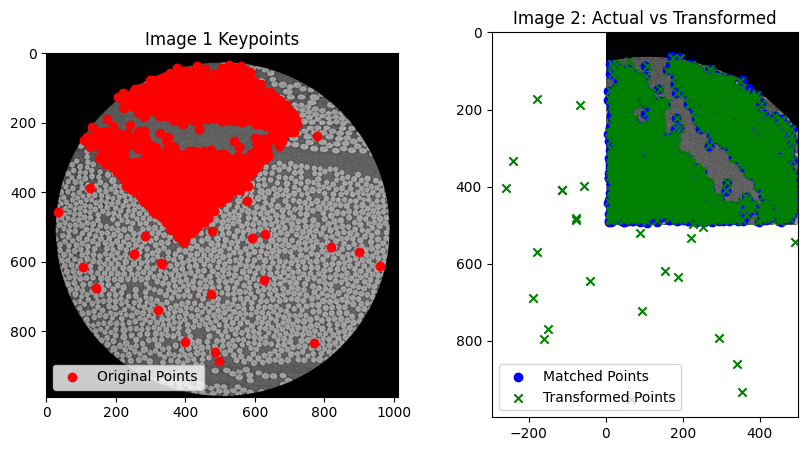

: 

In [ ]:
# Optional: print the number of matching points
print("Number of matching points:", len(p_set))

# Step 6: Compute the transformation parameters using your functions

# Compute the uniform scale factor
s = compute_scale(p_set, q_set)
print("Computed scale:", s)

# Compute the rotation matrix
R = covariance_matrix(p_set, q_set)
print("Computed rotation matrix:\n", R)

# Compute the translation vector
t = translation(p_set, q_set, R, s)
print("Computed translation vector:", t)

# Transform all keypoints from image1 using the computed transformation
transformed_points = [transform_pt(p, s, R, t) for p in p_set]

# Convert to numpy array for easier manipulation if needed
transformed_points = np.array(transformed_points)

# (Optional) Visualization: plot the transformed keypoints and actual keypoints from image2
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image_1, cv2.COLOR_BGRA2RGB))
plt.scatter(p_set[:, 0], p_set[:, 1], marker='o', color='red', label='Original Points')
plt.title("Image 1 Keypoints")
plt.legend()

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(image_2, cv2.COLOR_BGRA2RGB))
plt.scatter(q_set[:, 0], q_set[:, 1], marker='o', color='blue', label='Matched Points')
plt.scatter(transformed_points[:, 0], transformed_points[:, 1], marker='x', color='green', label='Transformed Points')
plt.title("Image 2: Actual vs Transformed")
plt.legend()
plt.show()